# 1. Utilities

## 1.1 Imports


In [25]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_clean import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Create Environment


In [26]:
# environment hyperparams
#option 1 :  use n_updates to define n_steps
n_updates = 50000
n_envs = 1
n_steps_per_update = 1
n_steps = n_envs * n_steps_per_update * n_updates

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
#envs = gym.vector.make("CartPole-v1", num_envs=n_envs)
env = gym.make("CartPole-v1")

obs_shape = env.observation_space.shape[0]
print(obs_shape)
action_shape = env.action_space.n
print(action_shape)
# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

4
2


In [27]:
# LOGGED VARIABLES
critic_losses = []
actor_losses = []
entropies = []
episode_returns = []
steps_episodes = [] # logs the steps taken in each episode

# COUNTERS
steps = 0
ep_counter = 0
ep_reward = 0

# VARIABLE INITIALIZATION
is_truncated = False
is_terminated = False
state, info = env.reset(seed=42)



# use tqdm to get a progress bar for training
for steps in tqdm(range(n_steps)):

    # reset environment if truncated or terminated
    if is_truncated == True or is_terminated == True:
        states, info = env.reset(seed=42)
        is_truncated = False
        is_terminated = False
        ep_counter += 1
        steps_episodes.append(steps)
        episode_returns.append(ep_reward)
        ep_reward = 0

        


    # reset lists that collect experiences of a n_steps_per_update
    n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    # don't take mask and reward gradient
    masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
    n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)

    # play n_steps_per_update to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent, get actions and values Vt
        actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False)

        # ensure no grad is taken in the step
        with torch.no_grad():
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            states, reward, is_terminated, is_truncated, infos = env.step(
                actions.cpu().numpy()
            )
            ep_reward += reward # increase episode return
            mask = not is_terminated # define mask for bootstrapping

        # log the value, reward and action log prob of the last step
        n_value_preds[step] = torch.squeeze(V_t)
        n_rewards[step] = torch.tensor(reward, device=device)
        n_action_log_probs[step] = action_log_probs

        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor(mask) # allows for correct bootstrapping
        #TODO : test for n_steps
        # stop the n_steps collection if episode is finished
        if is_terminated or is_truncated :
            break

    states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        n_rewards,
        n_action_log_probs,
        n_value_preds,
        entropy,
        masks,
        gamma,
        states_tensor,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())





 21%|██▏       | 10698/50000 [00:22<01:24, 466.90it/s]


KeyboardInterrupt: 

[14, 44, 66, 85, 96, 106, 118, 130, 150, 179, 198, 212, 227, 239, 256, 269, 304, 323, 345, 363, 375, 390, 405, 444, 455, 471, 493, 512, 522, 530, 552, 564, 590, 608, 621, 637, 667, 678, 689, 702, 728, 745, 777, 822, 846, 874, 888, 913, 950, 964, 979, 1016, 1031, 1050, 1063, 1087, 1100, 1119, 1133, 1190, 1230, 1243, 1270, 1289, 1303, 1326, 1344, 1360, 1384, 1403, 1420, 1457, 1469, 1549, 1577, 1597, 1645, 1669, 1718, 1751, 1774, 1797, 1829, 1843, 1880, 1896, 1921, 1936, 1962, 2005, 2056, 2084, 2126, 2198, 2230, 2278, 2351, 2374, 2392, 2422, 2476, 2498, 2512, 2531, 2554, 2578, 2588, 2619, 2637, 2666, 2679, 2709, 2736, 2762, 2788, 2817, 2844, 2869, 2898, 2919, 2959, 2988, 3017, 3057, 3096, 3119, 3169, 3290, 3332, 3358, 3385, 3422, 3442, 3466, 3480, 3537, 3599, 3615, 3641, 3696, 3752, 3769, 3823, 3852, 3872, 3957, 4016, 4059, 4085, 4216, 4263, 4294, 4316, 4334, 4396, 4421, 4479, 4491, 4511, 4563, 4622, 4719, 4774, 4831, 4869, 4886, 4920, 4952, 4985, 5014, 5065, 5120, 5176, 5240, 5311, 5444,

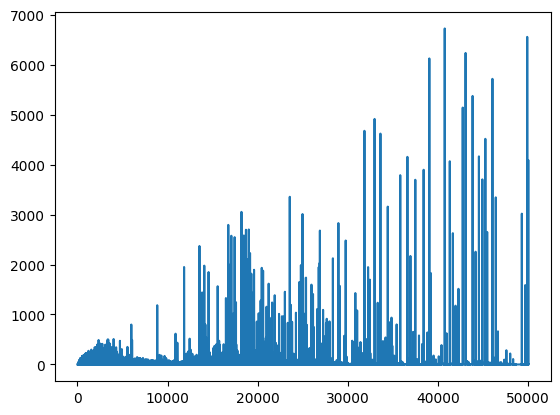

In [5]:

#plot evaluation
print(log_terminated_steps)
print("truncated",log_truncated_steps)
longueur = len(log_terminated_steps)
indexes = np.argsort(critic_losses)[-longueur:]
print(sorted(indexes))
print(np.mean(critic_losses))


#plt.plot(np.log(critic_losses))
plt.plot(critic_losses)
# plt.plot(evaluation_returns)
# Example list


# Get the indexes of the 10 largest values


#print(indexes)
# plt.title("Evaluation Returns")
# plt.xlabel("Evaluation number")
# plt.ylabel("Average return")




plt.show()


## saving/loading weights

In [9]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weightss.h5"
critic_weights_path = "weights/critic_weightss.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## SHOWCASE

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 

### 1.2.1 Printing informations

In [ ]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print("------")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

NameError: name 'env' is not defined

## 1.3 Define the A2C Class


# 2. Running the Agents (Discrete Case)


A2C.py and then we merge


In [ ]:
from A2C import *

## 1.4 Training function



train.py and then we merge


In [ ]:
from training import *

## 1.5 Evaluation functions

# 2. Running the Agents (Discrete Case)


## 2.1 Agent 1

# 3. Running the Agents (Continuous Case)
